# Info

This code is extracting and visualizing news stories from a set of news articles. 

The data and the code are supplements to "Real-time News Story Detection and Tracking with Hashtags" paper by Gevorg Poghosyan and Georgiana Ifrim presented at the second Workshop on Computing News Storylines co-located with  EMNLP 2016.
The paper is available for downloading here http://aclweb.org/anthology/W/W16/W16-5703.pdf .
The data and the code can be found here https://github.com/gevra/may2016-stories .

The script requires the Eclat implementation by Christian Borgelt, which can be found here http://www.borgelt.net/eclat.html .

For queries, contact gevorg.poghosyan@insight-centre.org

# Initialize and specify the story

In [1]:
import sys
import re
import os.path
import pickle
import itertools
import time
import datetime
import json
import pandas as pd
import numpy as np
import multiprocessing as mp
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
# import mpld3
# mpld3.enable_notebook()
from pytz import timezone
dublin_time = timezone('Europe/Dublin')

# from IPython.core.display import Javascript, HTML, display

In [2]:
csv_file_name = 'articles_2016.05.01-2016.05.31'

## Retrieve the articles

### Put articles in a pandas dataframe

In [3]:
articles_searched_df = pd.read_csv(csv_file_name + ".csv", sep=",", header=0, index_col=0)

In [4]:
print(articles_searched_df.shape)
articles_searched_df.head()

(21816, 9)


,article_id,headline,datetime,source,keywords,havehashtag,numbertweets,all_hashtags,n_hashtags
0,243131,"If you die in Sweden, it's a month before you ...",2016-05-27T14:38:21+00:00,TheJournal,"sweden, don’t leave, swedes, month, moller",False,0,[],0
1,236027,Senators introduce bill to block expansion of ...,2016-05-19T15:14:00+00:00,Reuters,"thursday, washington a, change, fbi’s, fbi",False,41,[],0
2,235969,ECB frustrated over governments' delay on reforms,2016-05-19T13:49:20+00:00,RTÉ,"april, reforms, governments, central bank, ecb",True,50,"['#in', '#ecb']",2
3,235694,"Missing passenger plane has crashed, say Egypt...",2016-05-19T05:21:00+00:00,Independent,"egyptair, plane, paris, mediterranean, radar",True,63577,['#egyptair'],1
4,235972,BBC Sport,2016-05-19T13:59:49.902102+00:00,BBC,"bbc sport, dr tony xia, new aston villa, chels...",True,3209,['#avfc'],1


In [5]:
articles_searched_df.dtypes

article_id       int64
headline        object
datetime        object
source          object
keywords        object
havehashtag       bool
numbertweets     int64
all_hashtags    object
n_hashtags       int64
dtype: object

In [6]:
if not isinstance(articles_searched_df.iloc[-1]['all_hashtags'], list) :
    articles_searched_df['all_hashtags'] = articles_searched_df['all_hashtags'].map(lambda x: eval(x))
type(articles_searched_df.iloc[-1]['all_hashtags'])

list

In [7]:
count_tags_func = lambda x: len(x)
articles_searched_df['n_hashtags'] = articles_searched_df['all_hashtags'].map(count_tags_func)
articles_searched_df.head()

,article_id,headline,datetime,source,keywords,havehashtag,numbertweets,all_hashtags,n_hashtags
0,243131,"If you die in Sweden, it's a month before you ...",2016-05-27T14:38:21+00:00,TheJournal,"sweden, don’t leave, swedes, month, moller",False,0,[],0
1,236027,Senators introduce bill to block expansion of ...,2016-05-19T15:14:00+00:00,Reuters,"thursday, washington a, change, fbi’s, fbi",False,41,[],0
2,235969,ECB frustrated over governments' delay on reforms,2016-05-19T13:49:20+00:00,RTÉ,"april, reforms, governments, central bank, ecb",True,50,"[#in, #ecb]",2
3,235694,"Missing passenger plane has crashed, say Egypt...",2016-05-19T05:21:00+00:00,Independent,"egyptair, plane, paris, mediterranean, radar",True,63577,[#egyptair],1
4,235972,BBC Sport,2016-05-19T13:59:49.902102+00:00,BBC,"bbc sport, dr tony xia, new aston villa, chels...",True,3209,[#avfc],1


In [8]:
len(articles_searched_df[articles_searched_df['n_hashtags']==0])

8221

In [9]:
# count the unique hashtags
set_of_all_hashtags = set([])
for (i, a) in articles_searched_df.iterrows():
    set_of_all_hashtags = set_of_all_hashtags | set(a["all_hashtags"])
    
print("the number of unique hashtags is %d" % len(set_of_all_hashtags))

the number of unique hashtags is 5107


### Plot the distribution of recommended hashtags per article

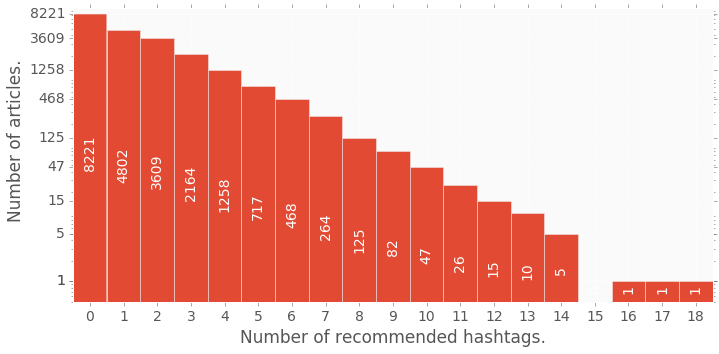

In [10]:
# histogram of n_hashtags
n_bins = max(set(articles_searched_df["n_hashtags"].tolist()))
fig, ax = plt.subplots(figsize=(10, 5))
# ax = articles_searched_df.hist(ax=ax, column="n_hashtags", bins=n_bins)[0]
counts, bins, patches = plt.hist(articles_searched_df["n_hashtags"].tolist(), bins=(-0.5 + np.arange(n_bins + 2)))
ax.set_yscale('log')
# pl.gca().set_yscale("log")
pl.xticks(np.arange(0, n_bins + 1), size=14)
pl.yticks(counts[::2], [int(c) for c in counts][::2], size=14)
pl.xlim([-0.5, n_bins + 0.5])
pl.ylim([0.5, 10000])
pl.xlabel("Number of recommended hashtags.", size=17)
pl.ylabel("Number of articles.", size=17)
ax.yaxis.set_label_coords(-0.075, 0.55)
pl.title("")
ax.set_axis_bgcolor((0.98, 0.98, 0.98))

for rect, label in zip(patches, [str(int(c)) for c in counts]):
    h = max(rect.get_height(), 1)
    ax.text(
        rect.get_x() + rect.get_width()/2, 
        h/max(7*np.log10(h)**2, 1.3), 
        label, 
        ha='center', 
        va='center', 
        rotation=90, 
        size=14,
        color='white'
    )

# pos = np.arange(18)
# ax.set_xticks(pos)
fig.tight_layout()
plt.savefig("hist_number_of_recommended_hashtags.pdf", bbox_inches='tight', transparent=False, pad_inches=0)

The plot abouve is the distribution of number of recommended hashtags per article in the full set of all (21,819 in May) articles from the given period. The hashtag count in the plot above includes also the spammy recommended hashtags.

### Export articles with their hashtags to a file

<br>

### Filter and export articles with their hashtags to a file for pattern mining

In [11]:
# export recommendations for pattern mining
hashtag_blacklist = ['#news', '#business', '#breaking', '#politics',
                         '#jobs', '#world', '#rt', '#sport', '#breakingnews', '#follow']
with open('%s_nospam.txt' % (csv_file_name), 'w') as f:
    for (i, a) in articles_searched_df[articles_searched_df['n_hashtags']>0].iterrows():
        if len([h for h in a['all_hashtags'] if h not in hashtag_blacklist]) > 0:
            f.write("%s\n" % 
                    (
                    #i, 
                    #a['article_id'], 
                    #articles_df[articles_df['article_id']==toa['article_id']]['Source'], 
                    ",".join([h for h in a['all_hashtags'] if h not in hashtag_blacklist])  # + a['keywords'].split(", ").replace(" ", "_"))
                    )
                   )

<br>

# Mine the patterns

In [12]:
# run ECLAT
!./eclat -C "%" -f "," -s-5  $csv_file_name"_nospam.txt" $csv_file_name"_nospam_eclat.out"

./eclat - find frequent item sets with the eclat algorithm
version 5.13 (2016.04.09)        (c) 2002-2016   Christian Borgelt
reading articles_2016.05.01-2016.05.31_nospam.txt ... [5097 item(s), 13270 transaction(s)] done [0.01s].
filtering, sorting and recoding items ... [1134 item(s)] done [0.00s].
sorting and reducing transactions ... [4401/13270 transaction(s)] done [0.00s].
writing articles_2016.05.01-2016.05.31_nospam_eclat.out ... [6839 set(s)] done [0.00s].


<br>

# Load the patterns and do stuff

In [13]:
# load the patterns to pandas
def product_func(row):
    return row[0] * row[1]

patterns_df = pd.read_csv(csv_file_name + "_nospam_eclat.out", sep="(", header=None, names=["pattern", "support"])

patterns_df["pattern"] = patterns_df["pattern"].map(lambda x: x.strip())
patterns_df["pattern_list"] = patterns_df["pattern"].map(lambda x: x.strip().split(" "))
patterns_df["support"] = patterns_df["support"].map(lambda x: int(x.replace(")", "")))
patterns_df["size"] = patterns_df["pattern_list"].map(lambda x: len(x))
patterns_df["area"] = patterns_df[["support", "size"]].apply(product_func, axis=1)

print("read the patterns from '%s_nospam_eclat.out' and produced a df of shape %s" % (csv_file_name, patterns_df.shape))

read the patterns from 'articles_2016.05.01-2016.05.31_nospam_eclat.out' and produced a df of shape (6839, 5)


In [14]:
# sort patterns by their area size
patterns_df.sort_values("area", axis=0, ascending=False, inplace=True, na_position='last')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78d0810dd8>]], dtype=object)

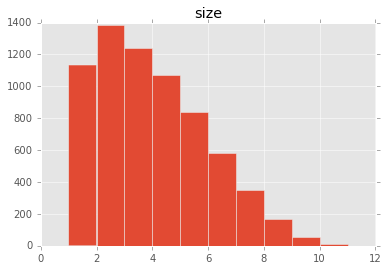

In [15]:
# produce a plot of number of patterns based on their length
patterns_df.hist(column="size")

In [16]:
###################################

use_partial = False
partial_name_appendix = ""
if use_partial:
    # patterns_df = patterns_df.head(3500)
    patterns_df = patterns_df[patterns_df["size"] < 5]
    partial_name_appendix = "_partial"

###################################

In [17]:
print("after filtering the shape of the dataframe is %s" % str(patterns_df.shape))
patterns_df.head(10)

after filtering the shape of the dataframe is (6839, 5)


,pattern,support,pattern_list,size,area
0,#mufc,758,[#mufc],1,758
6,#trump #trump2016,288,"[#trump, #trump2016]",2,576
33,#nevertrump #trump #trump2016,170,"[#nevertrump, #trump, #trump2016]",3,510
43,#trumptrain #trump2016 #trump,158,"[#trumptrain, #trump2016, #trump]",3,474
45,#trumptrain #nevertrump #trump #trump2016,101,"[#trumptrain, #nevertrump, #trump, #trump2016]",4,404
30,#nevertrump #trump2016,174,"[#nevertrump, #trump2016]",2,348
1,#brexit,345,[#brexit],1,345
34,#nevertrump #trump,171,"[#nevertrump, #trump]",2,342
3,#trump2016,334,[#trump2016],1,334
42,#trumptrain #trump,160,"[#trumptrain, #trump]",2,320


### find and populate the pattern children column

The following cell is a slow-running cell.

In [18]:
# find and populate the pattern children column

patterns_df_copy = patterns_df.copy() # copy is created in order to not modify the df when iterating over it
patterns_df["children_ids"] = patterns_df["pattern_list"]
for (idx, p) in patterns_df_copy.iterrows():
    # print(type(idx), type(p))
    # print([ii for (ii, pp) in patterns_df_copy.iterrows() if set(p["pattern_list"]).issubset(set(pp["pattern_list"]))])
    patterns_df.set_value(
        idx, 
        "children_ids", 
        [
            ii for (ii, pp) in patterns_df_copy[patterns_df_copy["size"] == p["size"] + 1].iterrows() 
            if set(p["pattern_list"]).issubset(set(pp["pattern_list"])) and ii != idx
        ]
    )
    # patterns_df.loc[idx, "children_ids"] = [ii for (ii, pp) in patterns_df_copy.iterrows() if set(p["pattern_list"]).issubset(set(pp["pattern_list"]))]

In [19]:
# create n_children column
patterns_df["n_children"] = patterns_df["children_ids"].map(lambda x: len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78cc142550>]], dtype=object)

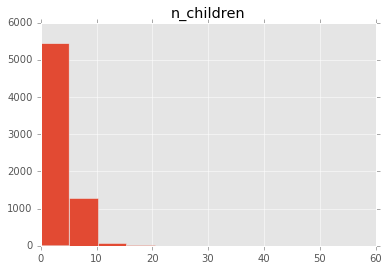

In [20]:
patterns_df.hist(column="n_children")

In [21]:
# export the patterns to CSV files

patterns_df.to_csv(
    csv_file_name.replace("articles_all", "patterns") + partial_name_appendix + '.csv', 
    header=False, 
    index=True
)
patterns_df.to_csv(
    csv_file_name.replace("articles_all", "patterns") + partial_name_appendix + '_with_header.csv', 
    header=True, 
    index=True
)

### Create and export the json for the visualization

This part will prepare the patterns for visualization. 

The following cell is a very slow-running cell.

In [ ]:
def populate_children_dict(p, patterns_df):
    list_of_children = []
    for c in p["children_ids"]:
        child_pattern_parent_removed = " ".join(list(set(patterns_df.loc[c]["pattern_list"]) - set(p["pattern_list"])))
        child = {
            "name": child_pattern_parent_removed, 
            "children": [
                {
                    "name": child_pattern_parent_removed,  # patterns_df.loc[c]["pattern"], 
                    "size": int(patterns_df.loc[c]["support"])  # The issue is that my integers are actually type numpy.int64
                }
            ]
        }
        if patterns_df.loc[c]["n_children"] > 0:
            child["children"] = child["children"] + populate_children_dict(patterns_df.loc[c], patterns_df)
        list_of_children.append(child)
    return list_of_children

In [ ]:
# export a json for plotting as here http://bl.ocks.org/mbostock/7607535

patterns_dict = {"name": "stories", "children": []}

for (i, p) in patterns_df[patterns_df["size"]==1].iterrows():
    singleton = {
        "name": p["pattern"], 
        "children": [
            {
                "name": "__%s__" % p["pattern"], 
                "size": int(p["support"])  # The issue is that my integers are actually type numpy.int64
            }
        ]
    }
    singleton["children"] = singleton["children"] + populate_children_dict(p, patterns_df)
    patterns_dict["children"].append(singleton)

In [ ]:
# export the dictionary of patterns to a json file
with open(csv_file_name.replace("articles_all", "patterns") + partial_name_appendix + '.json', 'w') as f:
    json.dump(patterns_dict, f)